moving forward with fusion approach, combining segmented glm and aggregate random forest
## ***Does aggregate glm outperform aggregate random forest?***

In [1]:
ls()

character(0)

In [2]:
options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)

In [3]:
library(dplyr)
library(data.table)
library(partykit)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(rPython)
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)

getwd()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: lattice

Loading required package: ggplot2

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘ranger’


The following object is masked from ‘package:randomForest’:

    importance



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:sta

[1] "/home/jupyter/local/Domains_202003/scripts/phaseII_04_fusion"

In [9]:

source('../orig/functions.R')

source('../orig/functions_models.R')

source('../phaseII_03_forest/functions_eval.R')


source('../phaseII_03_forest/load_prep_data_expiry.R')

# expiry_train_prepped_2_1 (list, less df's w/ 0 obs)
# expiry_test_prepped_2_1  (list, less df's w/ 0 obs)
# expiry_train_df_1 (above, rbound)
# expiry_test_df_1 (above, rbound)
# expiry_train_df_sub (subset vars)                                        
# expiry_test_df_sub (subset vars)

In [5]:
# processed glm test data
filename = 'seg_glm_expiry_exptest'
system(paste(sprintf("gsutil cp gs://data_input/%s /home/jupyter/local/Domains_202003/data/", filename)))
seg_glm_expiry_exptest <- readRDS(file.path("/home/jupyter/local/Domains_202003/data/", filename))

# Verify both prepped expiry & expiry glm test output is segmented on tld-reseller

In [10]:
seg_glm_expiry_exptest %>% select(tld,registrar,reseller,tld_registrar_index) %>% filter(registrar!=reseller) %>% head()

tld,registrar,reseller,tld_registrar_index
<fct>,<chr>,<chr>,<chr>
fun,ascio,active 24,funactive 24
fun,ascio,active 24,funactive 24
fun,ascio,active 24,funactive 24
fun,ascio,active 24,funactive 24
fun,ascio,active 24,funactive 24
fun,ascio,active 24,funactive 24


In [18]:
expiry_train_df_1 %>% select(tld,registrar,reseller,tld_registrar_index) %>% filter(registrar!=reseller) %>% head()

tld,registrar,reseller,tld_registrar_index
<fct>,<chr>,<chr>,<chr>
fun,ascio,active 24,funactive 24
fun,ascio,active 24,funactive 24
fun,ascio,active 24,funactive 24
fun,ascio,active 24,funactive 24
fun,ascio,active 24,funactive 24
fun,ascio,active 24,funactive 24


In [23]:
expiry_test_df_1 %>% select(tld,registrar,reseller,tld_registrar_index) %>% filter(registrar!=reseller) %>% head()

tld,registrar,reseller,tld_registrar_index
<fct>,<chr>,<chr>,<chr>
fun,ascio,active 24,funactive 24
fun,ascio,active 24,funactive 24
fun,ascio,active 24,funactive 24
fun,ascio,active 24,funactive 24
fun,ascio,active 24,funactive 24
fun,ascio,active 24,funactive 24


# Define top N tld_registrars (right now in perf_segmentation_tld_reg)

In [11]:
N = 15
top_tld_reg <- seg_glm_expiry_exptest %>% group_by(tld_registrar_index) %>% count() %>% arrange(desc(n)) %>% head(15) %>% select(n)
sum(top_tld_reg$n)

sum(top_tld_reg$n)/nrow(seg_glm_expiry_exptest)

tld_registrars = top_tld_reg$tld_registrar_index
tld_registrars

Adding missing grouping variables: `tld_registrar_index`



[1] 142366

[1] 0.4796747

[1] "sitegmo"                       "funalibaba"                   
 [3] "sitenamecheap"                 "pwnamecheap"                  
 [5] "onlinego daddy"                "sitegandi sas"                
 [7] "sitereg.ru"                    "onlinenamecheap"              
 [9] "siteonlinenic"                 "hostnamecheap"                
[11] "sitezhengzhou century connect" "funchengdu west"              
[13] "spacego daddy"                 "websitenamecheap"             
[15] "funnamecheap"

# Seg_GLM for top N tld_registrars

In [12]:
seg_glm_expiry_exptest_sub <- seg_glm_expiry_exptest %>% filter(tld_registrar_index %in% tld_registrars)

In [13]:
dim(seg_glm_expiry_exptest_sub)/dim(seg_glm_expiry_exptest)

[1] 0.4796747 1.0000000

In [14]:
head(seg_glm_expiry_exptest_sub)

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,reseller_country,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,first_renewal_prediction
<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>
FirstTime,1,2020-01-05,58999453,joymee.fun,2018-01-05,Active,fun,alibaba,alibaba,China,China,2,NA,Not Renewd,0,auto-renewal,unrealized,2020-01-05,Alibaba,Alibaba,9.5,4.75,1,6,6,4.75,funalibaba,joymee,l,6,6l,1,1.558145,3.81,joymee,1,1,1,0.3892428
FirstTime,1,2020-01-07,59109488,prophet.fun,2018-01-07,Active,fun,alibaba,alibaba,China,China,2,NA,Not Renewd,0,auto-renewal,unrealized,2020-01-07,Alibaba,Alibaba,9.5,4.75,1,6,6,4.75,funalibaba,prophet,l,7,7l,1,1.558145,6.76,prophet,1,1,1,0.3677247
FirstTime,1,2020-01-17,59590658,fuyintv.fun,2018-01-17,Active,fun,alibaba,alibaba,China,China,2,NA,Renewed,0,renewal,NA,2019-08-15,Alibaba,Alibaba,9.5,4.75,5,30,6,4.75,funalibaba,fuyintv,l,7,7l,1,1.558145,0.97,fuyintv,1,1,1,0.3334929
FirstTime,1,2020-01-21,59849738,mul.fun,2018-01-21,Active,fun,alibaba,alibaba,China,China,2,NA,Renewed,0,renewal,NA,2019-12-24,Alibaba,Alibaba,9.5,4.75,1,6,6,4.75,funalibaba,mul,l,3,3l,1,1.558145,5.71,mul,1,1,1,0.5258015
FirstTime,1,2020-02-05,60613428,12138.fun,2018-02-05,Active,fun,alibaba,alibaba,China,China,2,NA,Not Renewd,0,auto-renewal,unrealized,2020-02-05,Alibaba,Alibaba,9.5,4.75,1,6,6,4.75,funalibaba,12138,n,5,5n,1,1.558145,100.00,12138,1,1,1,0.4359649
FirstTime,1,2020-02-07,60745783,yimo.fun,2018-02-07,Active,fun,alibaba,alibaba,China,China,2,NA,Not Renewd,0,auto-renewal,unrealized,2020-02-07,Alibaba,Alibaba,9.5,4.75,1,6,6,4.75,funalibaba,yimo,l,4,4l,1,1.558145,4.61,yimo,1,1,1,0.4766606


In [15]:
head(expiry_train_df_1)

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,reseller_country,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count
<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>
FirstTime,1,2020-01-21,91584433,racefor.fun,2019-01-21,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-21,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,racefor,l,7,7l,1,2.70805,6.77,racefor,1,1,1
FirstTime,1,2020-01-30,92254793,united4.fun,2019-01-30,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-30,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,united4,ln,7,7ln,1,2.70805,8.65,united4,1,1,1
FirstTime,1,2020-02-04,92827233,bereal.fun,2019-02-04,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-04,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,bereal,l,6,6l,1,2.70805,13.09,bereal,1,1,1
FirstTime,1,2020-02-12,93490823,dogsoutdoors.fun,2019-02-12,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-02-12,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,dogsoutdoors,l,12,12l,1,2.70805,2.44,dogsoutdoors,1,1,1
FirstTime,1,2020-02-15,93767978,rosalux.fun,2019-02-15,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-15,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,rosalux,l,7,7l,1,2.70805,2.34,rosalux,1,1,1
FirstTime,1,2020-02-16,93823708,verygood.fun,2019-02-16,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-16,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,verygood,l,8,8l,1,2.70805,3.64,verygood,1,1,1


# RF on the rest 

In [16]:
tld_registrars
num_trees = 1000
train = expiry_train_df_sub
test = expiry_test_df_sub


train$tld_registrar_index <- tolower(paste(train$tld,
                                           train$reseller,sep=""))
test$tld_registrar_index <- tolower(paste(test$tld,
                                          test$reseller,sep=""))

train <- train %>% filter(!(tld_registrar_index %in% tld_registrars))
test <- test %>% filter(!(tld_registrar_index %in% tld_registrars))

nrow(train)/nrow(expiry_train_df_sub)
head(train)

[1] "sitegmo"                       "funalibaba"                   
 [3] "sitenamecheap"                 "pwnamecheap"                  
 [5] "onlinego daddy"                "sitegandi sas"                
 [7] "sitereg.ru"                    "onlinenamecheap"              
 [9] "siteonlinenic"                 "hostnamecheap"                
[11] "sitezhengzhou century connect" "funchengdu west"              
[13] "spacego daddy"                 "websitenamecheap"             
[15] "funnamecheap"

[1] 0.5214096

renewal_status,tld,reseller,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>
Renewed,fun,1&1 internet,Germany,Non China,1,l,7,1,6.77,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,ln,7,1,8.65,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,6,1,13.09,1,15,fun1&1 internet
Not Renewd,fun,1&1 internet,Germany,Non China,1,l,12,1,2.44,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,7,1,2.34,1,15,fun1&1 internet
Renewed,fun,1&1 internet,Germany,Non China,1,l,8,1,3.64,1,15,fun1&1 internet


In [20]:

paste(names(train), collapse=" + ")

[1] "renewal_status + tld + reseller + reseller_country + region + reg_period + sld_type + sld_length + day_domains + gibb_score + pattern_domain_count + reg_arpt + tld_registrar_index"

In [22]:
cat("\nTraining & Testing remaining aggregate forest.\n")

ranger_03_reg <- ranger(
formula         = renewal_status ~ tld + reseller + reseller_country + 
                            region + reg_period + sld_type + sld_length + day_domains + 
                            gibb_score + pattern_domain_count + reg_arpt,
data            = train, 
importance      = 'impurity', 
num.trees       = num_trees,
    probability     = TRUE,
#     mtry            = 3,
#     min.node.size   = 10,
#     replace         = FALSE,
#     sample.fraction = .8,
seed            = 123
)

ranger_predict_03_reg <- predict(ranger_03_reg, 
                                 data = test,
                                 type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed


Training & Testing remaining aggregate forest.
Growing trees.. Progress: 18%. Estimated remaining time: 2 minutes, 24 seconds.
Growing trees.. Progress: 36%. Estimated remaining time: 1 minute, 52 seconds.
Growing trees.. Progress: 53%. Estimated remaining time: 1 minute, 22 seconds.
Growing trees.. Progress: 71%. Estimated remaining time: 50 seconds.
Growing trees.. Progress: 89%. Estimated remaining time: 19 seconds.


In [24]:
test$first_renewal_prediction <- ranger_predict_03_reg
head(test)

renewal_status,tld,reseller,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index,first_renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>
Renewed,fun,1&1 internet,Germany,Non China,1,l,6,1,2.23,1,15,fun1&1 internet,0.4890293
Renewed,fun,1&1 internet,Germany,Non China,1,l,9,1,3.45,1,15,fun1&1 internet,0.4570346
Not Renewd,fun,10dencehispahard,Spain,Non China,1,l,8,1,8.62,1,15,fun10dencehispahard,0.5571666
Not Renewd,fun,10dencehispahard,Spain,Non China,1,l,6,1,3.13,1,15,fun10dencehispahard,0.5202203
Renewed,fun,1api,Germany,Non China,1,l,7,1,4.51,1,5,fun1api,0.4847403
Not Renewd,fun,1api,Germany,Non China,1,l,7,1,6.09,1,5,fun1api,0.4571582


In [25]:
dim(test)

[1] 154431     14

In [28]:
test_full <- expiry_test_df_1
test_full$tld_registrar_index <- tolower(paste(test_full$tld,
                                               test_full$reseller,sep=""))
test_full <- test_full %>% filter(!(tld_registrar_index %in% tld_registrars))

dim(test_full)

[1] 154431     39

In [29]:
test_full$first_renewal_prediction <- ranger_predict_03_reg
head(test_full)

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,reseller_country,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,first_renewal_prediction
<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>
FirstTime,1,2020-01-22,91639803,segeln.fun,2019-01-22,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-22,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,segeln,l,6,6l,1,2.708050,2.23,segeln,1,1,1,0.4890293
FirstTime,1,2020-03-07,95819759,harzhotel.fun,2019-03-07,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-03-07,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,harzhotel,l,9,9l,1,2.708050,3.45,harzhotel,1,1,1,0.4570346
FirstTime,1,2020-01-15,91044973,movistar.fun,2019-01-15,Active,fun,10dencehispahard,10dencehispahard,Spain,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-01-15,10dencehispahard,10dencehispahard,15,15,1,15,15,15,fun10dencehispahard,movistar,l,8,8l,1,2.708050,8.62,movistar,1,1,1,0.5571666
FirstTime,1,2020-02-01,92472913,kuinik.fun,2019-02-01,Active,fun,10dencehispahard,10dencehispahard,Spain,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-02-01,10dencehispahard,10dencehispahard,15,15,1,15,15,15,fun10dencehispahard,kuinik,l,6,6l,1,2.708050,3.13,kuinik,1,1,1,0.5202203
FirstTime,1,2020-01-21,91532433,bulgari.fun,2019-01-21,Active,fun,1api,1api,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-21,1API,1API,5,5,1,15,15,5,fun1api,bulgari,l,7,7l,1,1.609438,4.51,bulgari,1,1,1,0.4847403
FirstTime,1,2020-04-24,101717674,gotsome.fun,2019-04-24,Active,fun,1api,1api,Germany,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-04-24,1API,1API,5,5,1,15,15,5,fun1api,gotsome,l,7,7l,1,1.609438,6.09,gotsome,1,1,1,0.4571582


# GLM on rest

In [30]:
length(tld_registrars)
# expiry_train_prepped_2_1_sub <- list.remove(expiry_train_prepped_2_1, tld_registrars)
# expiry_train_prepped_2_1_sub <- expiry_train_prepped_2_1[names(expiry_train_prepped_2_1) %in% tld_registrars == FALSE]

expiry_train_df_1_sub <- expiry_train_df_1 %>% filter(!(tld_registrar_index %in% tld_registrars))
length(unique(expiry_train_df_1$tld_registrar_index))
length(unique(expiry_train_df_1_sub$tld_registrar_index))

expiry_test_df_1_sub <- expiry_test_df_1 %>% filter(!(tld_registrar_index %in% tld_registrars))
length(unique(expiry_test_df_1$tld_registrar_index))
length(unique(expiry_test_df_1_sub$tld_registrar_index))

# expiry_train_prepped_2_1 (list, less df's w/ 0 obs)
# expiry_test_prepped_2_1  (list, less df's w/ 0 obs)

[1] 15

[1] 1723

[1] 1708

[1] 1405

[1] 1390

In [31]:
head(expiry_train_df_1_sub)

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,reseller_country,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count
<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>
FirstTime,1,2020-01-21,91584433,racefor.fun,2019-01-21,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-21,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,racefor,l,7,7l,1,2.70805,6.77,racefor,1,1,1
FirstTime,1,2020-01-30,92254793,united4.fun,2019-01-30,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-30,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,united4,ln,7,7ln,1,2.70805,8.65,united4,1,1,1
FirstTime,1,2020-02-04,92827233,bereal.fun,2019-02-04,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-04,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,bereal,l,6,6l,1,2.70805,13.09,bereal,1,1,1
FirstTime,1,2020-02-12,93490823,dogsoutdoors.fun,2019-02-12,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-02-12,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,dogsoutdoors,l,12,12l,1,2.70805,2.44,dogsoutdoors,1,1,1
FirstTime,1,2020-02-15,93767978,rosalux.fun,2019-02-15,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-15,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,rosalux,l,7,7l,1,2.70805,2.34,rosalux,1,1,1
FirstTime,1,2020-02-16,93823708,verygood.fun,2019-02-16,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-16,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,verygood,l,8,8l,1,2.70805,3.64,verygood,1,1,1


In [50]:
# model fitting: 335.093 sec elapsed (8 core)
tic("model fitting")
first_renewal_model_expiry_train_agg <- build_model_first_renewal_agg(expiry_train_df_1_sub)
toc()
# tic("model saving")
# saveRDS(first_renewal_model_expiry_train, "../../data/output/first_renewal_model_expiry_train")
# toc()


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


model fitting: 766.265 sec elapsed


In [53]:
seg_glm_expiry_agg <- predict_first_renewal_agg(expiry_test_df_1_sub, first_renewal_model_expiry_train_agg)

In [54]:
head(seg_glm_expiry_agg)

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,reseller_country,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,probabilities,first_renewal_prediction
<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>
FirstTime,1,2020-01-22,91639803,segeln.fun,2019-01-22,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-22,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,segeln,l,6,6l,1,2.708050,2.23,segeln,1,1,1,0.5033386,0.503
FirstTime,1,2020-03-07,95819759,harzhotel.fun,2019-03-07,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-03-07,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,harzhotel,l,9,9l,1,2.708050,3.45,harzhotel,1,1,1,0.4872029,0.487
FirstTime,1,2020-01-15,91044973,movistar.fun,2019-01-15,Active,fun,10dencehispahard,10dencehispahard,Spain,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-01-15,10dencehispahard,10dencehispahard,15,15,1,15,15,15,fun10dencehispahard,movistar,l,8,8l,1,2.708050,8.62,movistar,1,1,1,0.1668106,0.167
FirstTime,1,2020-02-01,92472913,kuinik.fun,2019-02-01,Active,fun,10dencehispahard,10dencehispahard,Spain,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-02-01,10dencehispahard,10dencehispahard,15,15,1,15,15,15,fun10dencehispahard,kuinik,l,6,6l,1,2.708050,3.13,kuinik,1,1,1,0.1645742,0.165
FirstTime,1,2020-01-21,91532433,bulgari.fun,2019-01-21,Active,fun,1api,1api,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-21,1API,1API,5,5,1,15,15,5,fun1api,bulgari,l,7,7l,1,1.609438,4.51,bulgari,1,1,1,0.4077363,0.408
FirstTime,1,2020-04-24,101717674,gotsome.fun,2019-04-24,Active,fun,1api,1api,Germany,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-04-24,1API,1API,5,5,1,15,15,5,fun1api,gotsome,l,7,7l,1,1.609438,6.09,gotsome,1,1,1,0.4125760,0.413


# Aggregate Results -- seg_glm + agg_rf

In [55]:
cols = names(test)
cols

[1] "renewal_status"           "tld"                     
 [3] "reseller"                 "reseller_country"        
 [5] "region"                   "reg_period"              
 [7] "sld_type"                 "sld_length"              
 [9] "day_domains"              "gibb_score"              
[11] "pattern_domain_count"     "reg_arpt"                
[13] "tld_registrar_index"      "first_renewal_prediction"

In [56]:
dim(seg_glm_expiry_exptest_sub %>% select(all_of(cols)))

[1] 142366     14

In [57]:
dim(test)

[1] 154431     14

In [58]:
agg_results = rbind(seg_glm_expiry_exptest_sub %>% select(all_of(cols)), 
                    test)
dim(agg_results)
dim(seg_glm_expiry_exptest)
dim(seg_glm_expiry_exptest)-dim(agg_results)
head(agg_results)

[1] 296797     14

[1] 296797     40

[1]  0 26

renewal_status,tld,reseller,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index,first_renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>
Not Renewd,fun,alibaba,China,China,2,l,6,1,3.81,1,4.75,funalibaba,0.3892428
Not Renewd,fun,alibaba,China,China,2,l,7,1,6.76,1,4.75,funalibaba,0.3677247
Renewed,fun,alibaba,China,China,2,l,7,1,0.97,1,4.75,funalibaba,0.3334929
Renewed,fun,alibaba,China,China,2,l,3,1,5.71,1,4.75,funalibaba,0.5258015
Not Renewd,fun,alibaba,China,China,2,n,5,1,100.00,1,4.75,funalibaba,0.4359649
Not Renewd,fun,alibaba,China,China,2,l,4,1,4.61,1,4.75,funalibaba,0.4766606


# Aggregate Results -- seg_glm + agg_glm

In [59]:
agg_results2 = rbind(seg_glm_expiry_exptest_sub %>% select(all_of(cols)), 
                     seg_glm_expiry_agg %>% select(all_of(cols)))
dim(agg_results2)
dim(seg_glm_expiry_exptest)
dim(seg_glm_expiry_exptest)-dim(agg_results2)
head(agg_results2)

[1] 296797     14

[1] 296797     40

[1]  0 26

renewal_status,tld,reseller,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index,first_renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>
Not Renewd,fun,alibaba,China,China,2,l,6,1,3.81,1,4.75,funalibaba,0.3892428
Not Renewd,fun,alibaba,China,China,2,l,7,1,6.76,1,4.75,funalibaba,0.3677247
Renewed,fun,alibaba,China,China,2,l,7,1,0.97,1,4.75,funalibaba,0.3334929
Renewed,fun,alibaba,China,China,2,l,3,1,5.71,1,4.75,funalibaba,0.5258015
Not Renewd,fun,alibaba,China,China,2,n,5,1,100.00,1,4.75,funalibaba,0.4359649
Not Renewd,fun,alibaba,China,China,2,l,4,1,4.61,1,4.75,funalibaba,0.4766606


# Assess performance

In [60]:
df = data.frame("actual" = agg_results$renewal_status,
          "predicted" = agg_results$first_renewal_prediction)

lift_df <- chart_lift(pred_df = df,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot <- plot_gains (lift_df) 

auc_val <- calc_auc(lift_df)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

In [61]:
auc_val

[1] 0.7961167

In [62]:
lift_df

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,11401,0.4198490,4.198490
0.2,16725,0.6159087,3.079543
0.3,20178,0.7430676,2.476892
0.4,22873,0.8423126,2.105782
0.5,24765,0.9119867,1.823973
0.6,25843,0.9516848,1.586141
0.7,26667,0.9820291,1.402899
0.8,27013,0.9947708,1.243463
0.9,27143,0.9995581,1.110620


In [63]:
df2 = data.frame("actual" = agg_results2$renewal_status,
          "predicted" = agg_results2$first_renewal_prediction)

lift_df2 <- chart_lift(pred_df = df2,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot2 <- plot_gains (lift_df2) 

auc_val2 <- calc_auc(lift_df2)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

In [64]:
auc_val2

[1] 0.8206905

In [65]:
lift_df2

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,12614,0.4645185,4.645185
0.2,18346,0.6756030,3.378015
0.3,21812,0.8032407,2.677469
0.4,24088,0.8870558,2.217639
0.5,25296,0.9315412,1.863082
0.6,26218,0.9654944,1.609157
0.7,26752,0.9851593,1.407370
0.8,27019,0.9949917,1.243740
0.9,27136,0.9993003,1.110334


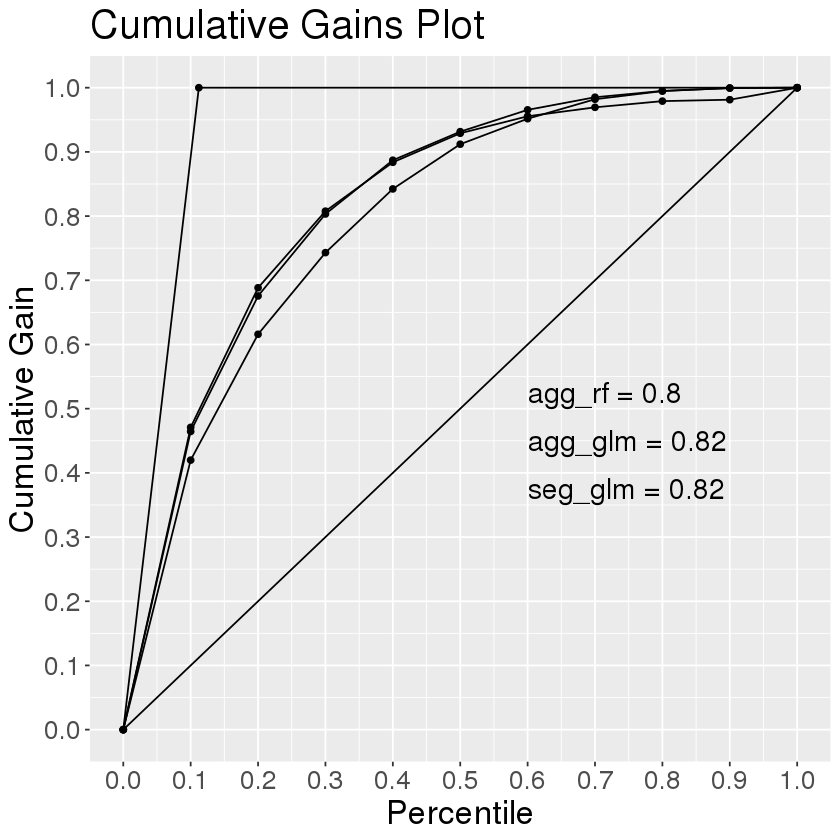

In [66]:
lift_df_seg_glm_expiry_exptest <- readRDS('../../data/lift_df_seg_glm_expiry_exptest')
plot_multigains <- plot_multigains(
    lift_df_list=list(
        agg_rf = lift_df,
        agg_glm = lift_df2,
        seg_glm = lift_df_seg_glm_expiry_exptest),
    auc_list = list(
        agg_rf = calc_auc(lift_df),
        agg_glm = calc_auc(lift_df2),
        seg_glm = calc_auc(lift_df_seg_glm_expiry_exptest)))
# png(file = "../../data/output/plot_multigains_03_summ5.png",
#     width = 500, height = 375)
plot(plot_multigains)
# dev.off()

In [67]:
calc_auc(lift_df_seg_glm_expiry_exptest)

[1] 0.8165071

In [68]:
lift_df_seg_glm_expiry_exptest

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,12787,0.4708893,4.708893
0.2,18692,0.6883447,3.441723
0.3,21933,0.8076966,2.692322
0.4,24000,0.8838151,2.209538
0.5,25227,0.9290002,1.858000
0.6,25947,0.9555146,1.592524
0.7,26325,0.9694347,1.384907
0.8,26587,0.9790830,1.223854
0.9,26647,0.9812926,1.090325


# Rerun seg_rf results (now w/ reseller instead of registrar)

In [11]:
num_trees = 1000
train = expiry_train_df_1
test = expiry_test_df_1

In [12]:
cat("\nTraining & Testing remaining aggregate forest.\n")

ranger_03_reg_full <- ranger(
formula         = renewal_status ~ tld + reseller + reseller_country + 
                            region + reg_period + sld_type + sld_length + day_domains + 
                            gibb_score + pattern_domain_count + reg_arpt,
data            = train, 
importance      = 'impurity', 
num.trees       = num_trees,
    probability     = TRUE,
#     mtry            = 3,
#     min.node.size   = 10,
#     replace         = FALSE,
#     sample.fraction = .8,
seed            = 123
)

ranger_predict_03_reg_full <- predict(ranger_03_reg_full, 
                                 data = test,
                                 type="response")$predictions

ranger_predict_03_reg_full <- as.data.frame(ranger_predict_03_reg_full)$Renewed


Training & Testing remaining aggregate forest.
Growing trees.. Progress: 7%. Estimated remaining time: 7 minutes, 40 seconds.
Growing trees.. Progress: 13%. Estimated remaining time: 6 minutes, 54 seconds.
Growing trees.. Progress: 20%. Estimated remaining time: 6 minutes, 18 seconds.
Growing trees.. Progress: 27%. Estimated remaining time: 5 minutes, 42 seconds.
Growing trees.. Progress: 34%. Estimated remaining time: 5 minutes, 7 seconds.
Growing trees.. Progress: 41%. Estimated remaining time: 4 minutes, 31 seconds.
Growing trees.. Progress: 48%. Estimated remaining time: 3 minutes, 59 seconds.
Growing trees.. Progress: 54%. Estimated remaining time: 3 minutes, 30 seconds.
Growing trees.. Progress: 61%. Estimated remaining time: 2 minutes, 58 seconds.
Growing trees.. Progress: 68%. Estimated remaining time: 2 minutes, 25 seconds.
Growing trees.. Progress: 76%. Estimated remaining time: 1 minute, 51 seconds.
Growing trees.. Progress: 83%. Estimated remaining time: 1 minute, 18 secon

In [13]:
test$first_renewal_prediction <- ranger_predict_03_reg_full
head(test)

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,reseller_country,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,first_renewal_prediction
<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>
FirstTime,1,2020-01-22,91639803,segeln.fun,2019-01-22,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-22,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,segeln,l,6,6l,1,2.708050,2.23,segeln,1,1,1,0.4887504
FirstTime,1,2020-03-07,95819759,harzhotel.fun,2019-03-07,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-03-07,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,harzhotel,l,9,9l,1,2.708050,3.45,harzhotel,1,1,1,0.4651045
FirstTime,1,2020-01-15,91044973,movistar.fun,2019-01-15,Active,fun,10dencehispahard,10dencehispahard,Spain,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-01-15,10dencehispahard,10dencehispahard,15,15,1,15,15,15,fun10dencehispahard,movistar,l,8,8l,1,2.708050,8.62,movistar,1,1,1,0.5977130
FirstTime,1,2020-02-01,92472913,kuinik.fun,2019-02-01,Active,fun,10dencehispahard,10dencehispahard,Spain,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-02-01,10dencehispahard,10dencehispahard,15,15,1,15,15,15,fun10dencehispahard,kuinik,l,6,6l,1,2.708050,3.13,kuinik,1,1,1,0.5226652
FirstTime,1,2020-01-21,91532433,bulgari.fun,2019-01-21,Active,fun,1api,1api,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-21,1API,1API,5,5,1,15,15,5,fun1api,bulgari,l,7,7l,1,1.609438,4.51,bulgari,1,1,1,0.4805170
FirstTime,1,2020-04-24,101717674,gotsome.fun,2019-04-24,Active,fun,1api,1api,Germany,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-04-24,1API,1API,5,5,1,15,15,5,fun1api,gotsome,l,7,7l,1,1.609438,6.09,gotsome,1,1,1,0.4653271


In [14]:
test_full <- expiry_test_df_1

test_full$first_renewal_prediction <- ranger_predict_03_reg_full
head(test_full)

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,reseller_country,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,first_renewal_prediction
<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>
FirstTime,1,2020-01-22,91639803,segeln.fun,2019-01-22,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-22,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,segeln,l,6,6l,1,2.708050,2.23,segeln,1,1,1,0.4887504
FirstTime,1,2020-03-07,95819759,harzhotel.fun,2019-03-07,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-03-07,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,harzhotel,l,9,9l,1,2.708050,3.45,harzhotel,1,1,1,0.4651045
FirstTime,1,2020-01-15,91044973,movistar.fun,2019-01-15,Active,fun,10dencehispahard,10dencehispahard,Spain,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-01-15,10dencehispahard,10dencehispahard,15,15,1,15,15,15,fun10dencehispahard,movistar,l,8,8l,1,2.708050,8.62,movistar,1,1,1,0.5977130
FirstTime,1,2020-02-01,92472913,kuinik.fun,2019-02-01,Active,fun,10dencehispahard,10dencehispahard,Spain,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-02-01,10dencehispahard,10dencehispahard,15,15,1,15,15,15,fun10dencehispahard,kuinik,l,6,6l,1,2.708050,3.13,kuinik,1,1,1,0.5226652
FirstTime,1,2020-01-21,91532433,bulgari.fun,2019-01-21,Active,fun,1api,1api,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-21,1API,1API,5,5,1,15,15,5,fun1api,bulgari,l,7,7l,1,1.609438,4.51,bulgari,1,1,1,0.4805170
FirstTime,1,2020-04-24,101717674,gotsome.fun,2019-04-24,Active,fun,1api,1api,Germany,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-04-24,1API,1API,5,5,1,15,15,5,fun1api,gotsome,l,7,7l,1,1.609438,6.09,gotsome,1,1,1,0.4653271


In [16]:
df3 = data.frame("actual" = test$renewal_status,
          "predicted" = test$first_renewal_prediction)

lift_df3 <- chart_lift(pred_df = df3,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot3 <- plot_gains (lift_df3) 

auc_val3 <- calc_auc(lift_df3)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

In [17]:
auc_val3

[1] 0.7596815

In [18]:
lift_df3

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,10790,0.3973486,3.973486
0.2,15550,0.5726386,2.863193
0.3,18529,0.6823421,2.274474
0.4,20958,0.7717916,1.929479
0.5,22958,0.8454428,1.690886
0.6,24567,0.9046953,1.507825
0.7,25707,0.9466765,1.352395
0.8,26630,0.9806665,1.225833
0.9,27025,0.9952127,1.105792


In [ ]:
plot_multigains <- plot_multigains(
    lift_df_list=list(
        _agg_rf = lift_df,
        _agg_glm = lift_df2,
        agg_rf = lift_df3,
        seg_glm = lift_df_seg_glm_expiry_exptest),
    auc_list = list(
        _agg_rf = calc_auc(lift_df),
        _agg_glm = calc_auc(lift_df2),
        agg_rf = calc_auc(lift_df3),
        seg_glm = calc_auc(lift_df_seg_glm_expiry_exptest)))
# png(file = "../../data/output/plot_multigains_03_summ5.png",
#     width = 500, height = 375)
plot(plot_multigains)
# dev.off()

In [24]:
# save(ranger_03_expiry2, file="../../data/output/ranger_03_expiry2")
# save(predict_ranger_03_expiry2, file="../../data/output/predict_ranger_03_expiry2")

system("gsutil cp /home/jupyter/local/Domains_202003/data/output/* gs://data_outputt/output/")
system("mv /home/jupyter/local/Domains_202003/data/output/* /home/jupyter/local/Domains_202003/data/")

# Compare agg_rf and agg_glm results
## Investigate why agg_rf test results has fewer rows than agg_glm

In [124]:
agg_rf_results <- data.frame(test_full)[c("domain","first_renewal_prediction","renewal_status","tld_registrar_index","registrar")]
names(agg_rf_results) <- c("domain","pred_rf","renewal_status","tld_registrar_index","registrar")
str(agg_rf_results)
head(agg_rf_results)

'data.frame':	152784 obs. of  5 variables:
 $ domain             : chr  "segeln.fun" "harzhotel.fun" "movistar.fun" "kuinik.fun" ...
 $ pred_rf            : num  0.65 0.671 0.611 0.501 0.806 ...
 $ renewal_status     : Factor w/ 2 levels "Renewed","Not Renewd": 1 1 2 2 1 2 2 2 2 2 ...
 $ tld_registrar_index: chr  "fun1&1 internet" "fun1&1 internet" "fun10dencehispahard" "fun10dencehispahard" ...
 $ registrar          : chr  "1&1 internet" "1&1 internet" "10dencehispahard" "10dencehispahard" ...


,domain,pred_rf,renewal_status,tld_registrar_index,registrar
,<chr>,<dbl>,<fct>,<chr>,<chr>
1,segeln.fun,0.6502946,Renewed,fun1&1 internet,1&1 internet
2,harzhotel.fun,0.6714504,Renewed,fun1&1 internet,1&1 internet
3,movistar.fun,0.6107611,Not Renewd,fun10dencehispahard,10dencehispahard
4,kuinik.fun,0.5011916,Not Renewd,fun10dencehispahard,10dencehispahard
5,bulgari.fun,0.8055027,Renewed,fun1api,1api
6,gotsome.fun,0.8044683,Not Renewd,fun1api,1api


In [125]:
agg_glm_results <- data.frame(seg_glm_expiry_agg)[c("domain","first_renewal_prediction","renewal_status","tld_registrar_index","registrar")]
names(agg_glm_results) <- c("domain","pred_glm","renewal_status","tld_registrar_index","registrar")
str(agg_glm_results)
head(agg_glm_results)

'data.frame':	154431 obs. of  5 variables:
 $ domain             : chr  "segeln.fun" "harzhotel.fun" "movistar.fun" "kuinik.fun" ...
 $ pred_glm           : num  0.518 0.502 0.169 0.166 0.426 0.432 0.266 0.279 0.295 0.293 ...
 $ renewal_status     : Factor w/ 2 levels "Renewed","Not Renewd": 1 1 2 2 1 2 2 2 2 2 ...
 $ tld_registrar_index: chr  "fun1&1 internet" "fun1&1 internet" "fun10dencehispahard" "fun10dencehispahard" ...
 $ registrar          : chr  "1&1 internet" "1&1 internet" "10dencehispahard" "10dencehispahard" ...


,domain,pred_glm,renewal_status,tld_registrar_index,registrar
,<chr>,<dbl>,<fct>,<chr>,<chr>
1,segeln.fun,0.518,Renewed,fun1&1 internet,1&1 internet
2,harzhotel.fun,0.502,Renewed,fun1&1 internet,1&1 internet
3,movistar.fun,0.169,Not Renewd,fun10dencehispahard,10dencehispahard
4,kuinik.fun,0.166,Not Renewd,fun10dencehispahard,10dencehispahard
5,bulgari.fun,0.426,Renewed,fun1api,1api
6,gotsome.fun,0.432,Not Renewd,fun1api,1api


In [126]:
agg_merged_results <- merge(agg_rf_results, 
                           agg_glm_results,
                           all.x = TRUE, all.y = TRUE, by=c('domain',"renewal_status"))

In [127]:
dim(agg_rf_results)
dim(agg_glm_results)
dim(agg_merged_results)

[1] 152784      5

[1] 154431      5

[1] 154431      8

In [128]:
head(agg_merged_results)

,domain,renewal_status,pred_rf,tld_registrar_index.x,registrar.x,pred_glm,tld_registrar_index.y,registrar.y
,<chr>,<fct>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,0-0-24.online,Not Renewd,0.32097057,onlinereg.ru,reg.ru,0.215,onlinereg.ru,reg.ru
2,0-1love.site,Not Renewd,0.04862976,sitealibaba,alibaba,0.019,sitealibaba,alibaba
3,0-2love.site,Not Renewd,0.04862976,sitealibaba,alibaba,0.019,sitealibaba,alibaba
4,0-6soso.site,Not Renewd,0.04457711,sitealibaba,alibaba,0.033,sitealibaba,alibaba
5,0-7love.site,Not Renewd,0.04862976,sitealibaba,alibaba,0.019,sitealibaba,alibaba
6,0-7soso.site,Not Renewd,0.04457711,sitealibaba,alibaba,0.033,sitealibaba,alibaba


In [129]:
agg_merged_results %>% filter(is.na(pred_rf)) %>% head()

,domain,renewal_status,pred_rf,tld_registrar_index.x,registrar.x,pred_glm,tld_registrar_index.y,registrar.y
,<chr>,<fct>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,052rasp5.site,Not Renewd,NA,NA,NA,0.101,sitevalue domain,gmo
2,0676bbj6.site,Not Renewd,NA,NA,NA,0.094,sitevalue domain,gmo
3,0defhiefhei.site,Not Renewd,NA,NA,NA,0.091,sitevalue domain,gmo
4,0qxht68o.site,Not Renewd,NA,NA,NA,0.096,sitevalue domain,gmo
5,0yp8vdnl.site,Not Renewd,NA,NA,NA,0.095,sitevalue domain,gmo
6,114510.site,Not Renewd,NA,NA,NA,0.165,sitemuumuu,gmo


In [130]:
agg_merged_results %>% filter(is.na(pred_rf)) %>% group_by(renewal_status) %>% tally()

renewal_status,n
<fct>,<int>
Renewed,191
Not Renewd,1456


In [142]:
agg_merged_results %>% filter(is.na(pred_rf)) %>% select(tld_registrar_index.y) %>% unique() 

,tld_registrar_index.y
,<chr>
1,sitevalue domain
6,sitemuumuu
8,sitetenten


In [144]:
agg_merged_results %>% filter(is.na(pred_rf)) %>% group_by(tld_registrar_index.y) %>% tally() 

tld_registrar_index.y,n
<chr>,<int>
sitemuumuu,394
sitetenten,776
sitevalue domain,477


In [148]:
agg_merged_results %>% group_by(tld_registrar_index.y) %>% tally() %>% arrange(desc(n)) %>% head()

tld_registrar_index.y,n
<chr>,<int>
sitealibaba,4369
onlinehostinger,4346
spacenamecheap,4273
websiteuniregistrar,4214
onlinealibaba,4134
onlinefbs,4077


In [132]:
agg_merged_results %>% filter(is.na(pred_rf)) %>% select(registrar.y) %>% unique()

,registrar.y
,<chr>
1,gmo


In [136]:
train$

Ranger result

Call:
 ranger(formula = renewal_status ~ ., data = train, importance = "impurity",      num.trees = num_trees, probability = TRUE, seed = 123) 

Type:                             Probability estimation 
Number of trees:                  1000 
Sample size:                      613054 
Number of independent variables:  12 
Mtry:                             3 
Target node size:                 10 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error (Brier s.):  0.08666443 

In [145]:
train %>% subset(tld_registrar_index %in% c("sitevalue domain","sitemuumuu","sitetenten"))

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,tld_registrar_index
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<chr>


In [153]:
train %>% subset(tld %in% c("site")) %>% group_by(registrar) %>% tally() %>% arrange(desc(n))

registrar,n
<chr>,<int>
alibaba,17785
go daddy,13644
chengdu west,12928
pdr ltd,12430
hostinger,8322
network solutions,7048
url solutions,5710
fbs,5312
dynadot,4099


In [154]:
train %>% subset((tld %in% c("site"))&(registrar %in% c("gmo"))) %>% group_by(registrar) %>% tally() %>% arrange(desc(n))

registrar,n
<chr>,<int>


In [1]:
names(expiry_train_df_1)

ERROR: Error in eval(expr, envir, enclos): object 'expiry_train_df_1' not found


In [159]:
expiry_train_df_1 %>% select(registrar) %>% unique() %>% dim()

[1] 176   1

In [160]:
expiry_train_df_1 %>% select(reseller) %>% unique() %>% dim()

[1] 309   1